In [1]:
import cv2
import os
import sys
import numpy as np 
import pandas as pd 
import tensorflow as tf 
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

import glob
from PIL import Image

Using TensorFlow backend.


In [2]:
raw_path = r'D:\Images for Object Recognition\DATASET'

In [3]:
read = lambda imname: np.asarray(Image.open(imname).convert("RGB").resize((224,224)))

In [4]:
data = []
label = []
for folder in os.listdir(raw_path):
    img_dir = os.path.join(raw_path,folder)
    data_path = os.path.join(img_dir,'*g')
    files = glob.glob(data_path)
    
    for f1 in files:
        ims = [read(f1)]
        data += ims
        label.append(folder)

img_array = np.array(data , dtype = 'uint8')

In [5]:
class_name = []
no_images = []
for folder in os.listdir( raw_path ):
    class_name.append(folder)
    image_files = os.path.join(raw_path,folder)
    no_images.append(len(os.listdir(image_files)))

In [6]:
import matplotlib.pyplot as plt

In [7]:
plot_df = pd.DataFrame()
plot_df['Class'] = class_name
plot_df['Images'] = no_images

In [8]:
plot_df

,Class,Images
0,Bottle,874
1,Cans,982
2,Cardboard,1061
3,Cups,614
4,Cutlery,996
5,Jars,1012
6,Laptop Accessories,1026
7,Organic Waste,1213
8,Paper,1008
9,Plastic Bag,671


<Figure size 2160x576 with 0 Axes>

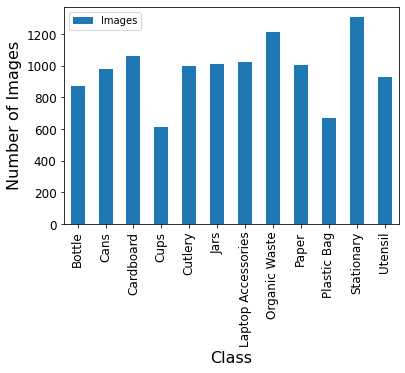

In [9]:
plt.figure(figsize=(30,8))
fig = plot_df.plot(x = 'Class', y = 'Images' , kind = 'bar')
fig.set_xlabel('Class', fontsize = 16)
fig.set_ylabel('Number of Images',fontsize = 16)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.show()

In [10]:
img_array.shape

(11696, 224, 224, 3)

In [11]:
from keras.applications.resnet50 import ResNet50

conv_base = ResNet50(weights = 'imagenet', include_top = False, input_shape = (224,224,3))

C:\Users\HP\anaconda3\envs\tensorflow_env\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [12]:
onehot_encoder = OneHotEncoder(sparse=False)
labels_arr = np.array([[i] for i in label]).reshape(len(label),1)
labels_encoded = onehot_encoder.fit_transform(labels_arr)

np.random.seed(2)

In [13]:
from keras.layers import Dropout

In [14]:
model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(256, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(len(labels_encoded[0]),activation = 'softmax'))

In [15]:
for layer in conv_base.layers:
    layer.trainable = False

In [16]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten_1 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               25690368  
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 12)                3084      
Total params: 49,281,164
Trainable params: 25,693,452
Non-trainable params: 23,587,712
_________________________________________________________________


In [17]:
import keras

In [18]:
optimizer = keras.optimizers.Adam(lr=1e-4)

In [19]:
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [20]:
from keras.preprocessing.image import ImageDataGenerator

In [21]:
train_X, validation_X, train_y, validation_y = train_test_split(img_array , labels_encoded , test_size = 0.20, shuffle=True, stratify=labels_encoded)

In [22]:
len(validation_X)

2340

In [23]:
datagen = ImageDataGenerator(
    rotation_range=40,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)
test_datagen = ImageDataGenerator(
    rescale=1./255,
)


batch_size = 32

In [24]:
filepath="weights.best2.hdf5"

In [25]:
callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, min_delta=1e-4, baseline=0.8300),
    keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
    ]


In [26]:
model.fit_generator(
    datagen.flow(train_X,train_y),
    steps_per_epoch=len(train_X) // batch_size,
    epochs=50,
    validation_data=test_datagen.flow(validation_X,validation_y),
    validation_steps=len(validation_X) // batch_size,
    callbacks= callbacks
)

Epoch 1/50
292/292 [==============================] - 2183s 7s/step - loss: 1.0954 - accuracy: 0.6739 - val_loss: 2.8033 - val_accuracy: 0.1498

Epoch 00001: val_accuracy improved from -inf to 0.14983, saving model to weights.best2.hdf5
Epoch 2/50
292/292 [==============================] - 2133s 7s/step - loss: 0.6080 - accuracy: 0.8101 - val_loss: 1.6508 - val_accuracy: 0.4588

Epoch 00002: val_accuracy improved from 0.14983 to 0.45884, saving model to weights.best2.hdf5
Epoch 3/50
292/292 [==============================] - 2123s 7s/step - loss: 0.4915 - accuracy: 0.8487 - val_loss: 0.7540 - val_accuracy: 0.7764

Epoch 00003: val_accuracy improved from 0.45884 to 0.77643, saving model to weights.best2.hdf5
Epoch 4/50
292/292 [==============================] - 2200s 8s/step - loss: 0.4324 - accuracy: 0.8590 - val_loss: 0.1488 - val_accuracy: 0.8488

Epoch 00004: val_accuracy improved from 0.77643 to 0.84879, saving model to weights.best2.hdf5
Epoch 5/50
292/292 [=======================

In [2]:
import pickle

In [3]:
loaded_model = pickle.load(open('best_model.sav', 'rb'))

In [30]:
filename='best_model.sav'
pickle.dump(model, open(filename, 'wb'))

In [7]:
import matplotlib.pyplot as plt

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


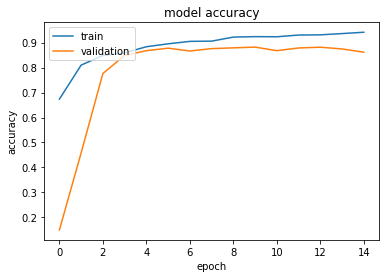

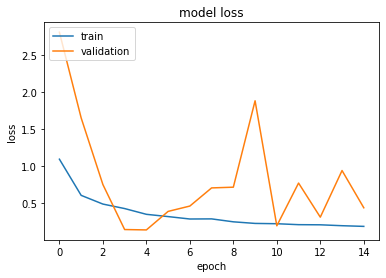

In [37]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()
# summarize history for loss
plt.plot([1.0954, 0.6080, 0.4915, 0.4324, 0.3539, 0.3230, 0.2922, 0.2916, 0.2533, 0.2311, 0.2267, 0.2148, 0.2131, 0.2004, 0.1909])
plt.plot([2.8033, 1.6508, 0.7540, 0.1488, 0.1437, 0.3928, 0.4648, 0.7089, 0.7187, 1.8810, 0.1992, 0.7741, 0.3153, 0.9425, 0.4416])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

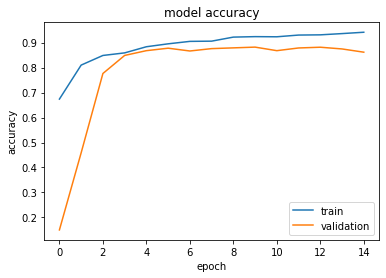

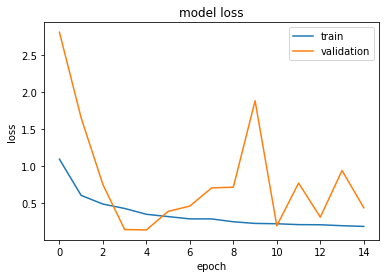

In [9]:

# summarize history for accuracy
plt.plot([0.6739, 0.8101, 0.8487, 0.8590, 0.8836, 0.8953, 0.9051, 0.9060, 0.9222, 0.9241, 0.9235, 0.9304, 0.9313, 0.9363, 0.9417])
plt.plot([0.1498, 0.4588, 0.7764, 0.8488, 0.8679, 0.8778, 0.8666, 0.8761, 0.8791, 0.8821, 0.8679, 0.8787, 0.8817, 0.8748, 0.8618])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()
# summarize history for loss
plt.plot([1.0954, 0.6080, 0.4915, 0.4324, 0.3539, 0.3230, 0.2922, 0.2916, 0.2533, 0.2311, 0.2267, 0.2148, 0.2131, 0.2004, 0.1909])
plt.plot([2.8033, 1.6508, 0.7540, 0.1488, 0.1437, 0.3928, 0.4648, 0.7089, 0.7187, 1.8810, 0.1992, 0.7741, 0.3153, 0.9425, 0.4416])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()